In [41]:
import os
import time
import random

import numpy as np
import gymnasium as gym

import matplotlib as mpl
import matplotlib.pyplot as plt

import autograd.numpy as anp
import scipy

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

%load_ext tensorboard
import tensorflow as tf

import datetime



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Parameters

In [42]:
height = 5                             # The height of the design space
width = 10                              # The width of the design space                   
number_of_nodes = height * width        # The number of nodes in the design space
bound_nodes_list = [(0, 0), (-1, 0)]    # A list containing the coordinates of 
                                        # the bounded nodes
loaded_nodes_list = [(-1, -1)]           # A list containing the coordinates of

In [43]:
# PHYSICAL PARAMETERS FOR THE FEM ANALYSIS
filter_width = 1
penal = 3.0
young_min = 1e-9
young = 1
poisson = 0.3
density = 1e-4
constraint_thresh = 0.5


_DESIGN = 0
_BOUND = 1
_FORCE = 2
_COMPLIANCE = 3
    

In [44]:
# TECHNICAL PARAMETERS FOR THE REINFORCEMENT LEARNING

number_subprocesses = 16     # The number of Threads to be used during the 
                            # learning process

log_dir = "log/"            # The directory of where to save the best model
ts_board_dir = "ts_board/"  # The directory of where to save the tensorboard files

ts = 5e6                    # The number of timesteps to be used during the 
                            # learning process

In [63]:
# This is for the used FEM analysis taken from the Gigala repository
# it saves the boundary nodes in a 3D array where the first two dimensions are 
# the coordinates of the node and the third dimension is the direction of the normal
normals = np.zeros((height + 1, width + 1, 2))
x = 0
y = 1
for coords in bound_nodes_list:
    normals[coords[x], coords[y], x] = 1
    normals[coords[x], coords[y], y] = 1
print(normals[:,:,0])

forces = np.zeros((height + 1, width + 1, 2))
forces[-1, -1, y] = -1
forces = forces.ravel()

fixdofs = np.flatnonzero(normals.ravel())
alldofs = np.arange(2 * (normals.shape[0]) * (normals.shape[1]))
freedofs = np.sort(list(set(alldofs) - set(fixdofs)))

print("Freedofs: ", freedofs)
print("Fixdofs: ", fixdofs)
print("Forces: ", forces)
print("length of Freedofs: ", len(freedofs))
print("length of Fixdofs: ", len(fixdofs))
print("length of Forces: ", len(forces))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Freedofs:  [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131]
Fixdofs:  [  0   1 110 111]
Forces:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [46]:
# Colormap for the plots
mpl.rcParams['image.cmap'] = 'YlOrBr'

In [47]:
def objective(x, freedofs, fixdofs, forces, volume_contraint=False, use_filter=True):
    """"Objective function for the topology optimization problem.
    Parameters
    ----------
    x : numpy.ndarray
        The design space.
    volume_contraint : bool, optional
        Whether to use the volume constraint.
    use_filter : bool, optional
        Whether to use the filter.
    Returns
    -------
    float
        The compliance of the design space.
    """
    kwargs = dict(penal=penal, e_min=young_min, e_0=young)
    x_phys = physical_density(x, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(young, poisson)
    u      = displace(x_phys, ke, forces, freedofs, fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c


def get_compliance(state, freedofs, fixdofs, forces):
    """This Function Provides an easy way to get the compliance of a state"""
    design = state


    reshape = lambda x: x.reshape(height, width)
    objective_fn = lambda x: objective(reshape(x), freedofs, fixdofs, forces)
    value = objective_fn(design)
    return value

def get_compliance_per_element(state, freedofs, fixdofs, forces):
    """This Function Provides an easy way to get the compliance of a state"""
    design = state
    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective_for_compliance_per_element(reshape(state), freedofs, fixdofs, forces)
    value = objective_fn(state)
    return value

def objective_for_compliance_per_element(x, freedofs, fixdofs, forces, volume_contraint=False, use_filter=True):
    """"Objective function for the topology optimization problem.
    Parameters
    ----------
    x : numpy.ndarray
        The design space.
    volume_contraint : bool, optional
        Whether to use the volume constraint.
    use_filter : bool, optional
        Whether to use the filter.
    Returns
    -------
    float
        The compliance of the design space.
    """
    kwargs = dict(penal=penal, e_min=young_min, e_0=young)
    x_phys = physical_density(x, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(young, poisson)
    u      = displace(x_phys, ke, forces, freedofs, fixdofs, **kwargs)
    c      = compliance_per_element(x_phys, u, ke, **kwargs)
    return c

Here we have the FEM function written by Gigala

In [48]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()

    return scipy.sparse.linalg.splu(a).solve



# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp




def compliance_per_element(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return C  
    
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    C = compliance_per_element(x_phys, u, ke, penal=penal, e_min=e_min, e_0=e_0)
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])


def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)


    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]






def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x,volume_contraint=False, use_filter=True):
    x = 1 * x.reshape(height, width)  # reshape from 1D to 2D
    return gaussian_filter(x, filter_width) if use_filter else x  # maybe filter

def mean_density(x, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, volume_contraint, use_filter))

# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')






def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm


In [49]:
def rewardFunction_old(state, freedofs, fixdofs, forces):
    """
    This is the Reward Function designed by Gigala

    -------
    Parameters:\n
    - state : numpy.ndarray
        - The design space.
    - freedofs : numpy.ndarray
        - The degrees of freedom that are free to move.
    - fixdofs : numpy.ndarray
        - The degrees of freedom that are fixed.
    - forces : numpy.ndarray
        - The forces applied to the design space.
    -------
    Returns:\n
    - float
        - The Reward of the design space.
    """
    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective(reshape(state), freedofs, fixdofs, forces)
    value = objective_fn(state)
    return ((1/value)**0.5) *10

def rewardFunction_1(matrix, freedofs, fixdofs, forces):
    """This is a "naive" Reward Function designed by me
    
    -------
    Parameters:\n
    - matrix : numpy.ndarray
        - The design space.
    - freedofs : numpy.ndarray
        - The degrees of freedom that are free to move.
    - fixdofs : numpy.ndarray
        - The degrees of freedom that are fixed.
    - forces : numpy.ndarray
        - The forces applied to the design space.
    -------
    Returns:\n
    - float
        - The Reward of the design space.
    """
    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective(reshape(state), freedofs, fixdofs, forces)
    value = objective_fn(matrix)
    reward = 20 / (np.sqrt(value)) / (constraintFunction(matrix))
    return round(reward, 5)

def rewardFunction_2(matrix, current_compliance, initial_compliance, last_compliance):
    # this is the Reward Function by Nathan Brown modified to fit the different
    # design space and different values used
    if current_compliance == 0 or initial_compliance == 0 or last_compliance == 0:
        print("\n\nRewardfunc Debug ====================================")
        print("Current Compliance: ", current_compliance)
        print("Initial Compliance: ", initial_compliance)
        print("Last Compliance: ", last_compliance)
        raise ValueError("something is wrong with the compliance values")
    comp_frac = ((initial_compliance/current_compliance))**2
    removed_node_frac = (get_removed_cells(matrix) / number_of_nodes)**2
    comp_frac_2 = current_compliance / last_compliance
    size_scalar = matrix.size / 50
    return (comp_frac + removed_node_frac - (comp_frac_2 / 100)) * size_scalar

def get_filled_cells(matrix):
    return sum(cell == 1 for row in matrix for cell in row)

def get_removed_cells(matrix):
    return sum(cell == density for row in matrix for cell in row)

def is_continuous(matrix, targets):
    if not targets:
        return False
    filled_cells = get_filled_cells(matrix)
    visited = dfs(matrix, targets)
    return False if len(visited) == 0 else len(visited) == filled_cells
 

def dfs(matrix, targets):
    """This function is the depth first search algorithm that is used to check 
    if all the filled cells in the design space are connected to a specified 
    start point.

    Parameters
    ----------
    matrix : numpy.ndarray
        The design space.
    start : tuple
        The coordinates of the start point.
    targets : tuple
        The coordinates of the end point.

    Returns
    -------
    set
        The set containing the visited nodes."""
    targets_copy = convert_all(targets.copy(), (height, width))
    start = targets_copy.pop(0)
    rows, cols = len(matrix), len(matrix[0]) 
    visited = set() # Set to keep track of visited nodes    
    stack = [start] # Start the stack with the start node
    if not stack:  # Check if the stack is empty
        raise RuntimeError("The stack is empty")
    while stack:
        (row, col) = stack.pop()    # pop the last coordinates from the stack
        if (row < 0 or 
            row >= rows or 
            col < 0 or 
            col >= cols or 
            (row, col) in visited or 
            matrix[row][col] == density): 
            #checking for discarding conditions
            continue
        if (row, col) in targets_copy:

            targets_copy.remove((row, col))
        visited.add((row, col))     # Add the current node to the visited set
        stack.extend([(row-1, col), (row+1, col), (row, col-1), (row, col+1),
                      (row-1, col-1), (row-1, col+1), (row+1, col-1), (row+1, col+1)])
        # Add the neighbours of the current node to the stack
 
    return visited if not targets_copy else []

def convert_relative_to_absolute(coord, matrix_dim):
    """
    Convert relative indices in a coordinate to absolute indices.

    Parameters:
    coord (tuple): The coordinate with potentially relative indices.
    matrix_dim (tuple): The dimensions of the matrix.

    Returns:
    tuple: The coordinate with absolute indices.
    """
    return tuple(dim + i if i < 0 else i for i, dim in zip(coord, matrix_dim))

def convert_all(coords, matrix_dim):
    """
    Convert all relative indices in a list of coordinates to absolute indices.

    Parameters:
    coords (list): The list of coordinates with potentially relative indices.
    matrix_dim (tuple): The dimensions of the matrix.

    Returns:
    list: The list of coordinates with absolute indices.
    """
    return list(map(lambda coord: convert_relative_to_absolute(coord, matrix_dim), coords))

def constraintFunction(state):
    reshape = lambda state: state.reshape(height, width)
    constraint = lambda params: mean_density(reshape(params)) 
    const = constraint(state)
    return const


x_bound_positions_for_scatter = [coord[1] for coord in convert_all(bound_nodes_list, (height, width))]
y_bound_positions_for_scatter = [coord[0] for coord in convert_all(bound_nodes_list, (height, width))]

x_loaded_positions_for_scatter = [coord[1] for coord in convert_all(loaded_nodes_list, (height, width))], 
y_loaded_positions_for_scatter = [coord[0] for coord in convert_all(loaded_nodes_list, (height, width))], 

In [66]:
def calculate_dofs(bounded_matrix):
    """A function that calculates the degrees of freedom of the design space
    based on the bounded nodes of the design space. They are calculated and 
    formatted in the correct way to use Gigala's FEM analysis. The degrees of
    Freedom are calculated for the Mesh grid of the FEM analyis. As this is of
    different dimensions than the design space, this function also needs to 
    transfer the information of the given Matrix into the Mesh grid of the FEM.
    ----------
    Parameters:\n
    - bounded_matrix : numpy.ndarray
        - A Matrix consisting of 0's and 1's representing the bounded Nodes
    -------
    Returns:\n
    - freedofs : numpy.ndarray
        - The degrees of freedom that are free to move.
    - fixdofs : numpy.ndarray
        - The degrees of freedom that are fixed."""
    rows, cols = bounded_matrix.shape
    normals = np.zeros((rows + 1, cols + 1, 2))
    for i in range(2):
        normals[:, :, i] = get_mesh_matrix(bounded_matrix)
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (normals.shape[0]) * (normals.shape[1]))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    return freedofs, fixdofs

def calculate_forces(force_matrix):
    """A function that calculates the forces array used for the gigala based on 
    FEM analysis using given force_matrix. The Forces are calculated for the 
    Mesh grid of the FEM analyis. As this is of different dimensions than the 
    design space, this function also needs to transfer the information of the 
    given Matrix into the Mesh grid of the FEM.
    ----------
    Parameters:\n
    - force_matrix : numpy.ndarray
        - A Matrix consisting of 0's and 1's representing the loaded Nodes
    -------
    Returns:\n
    - forces : numpy.ndarray
        - The forces applied to the design space."""
    rows, cols = force_matrix.shape
    forces = np.zeros((rows+1, cols+1, 2))
    for i in range(2):
        forces[:, :, i] = get_mesh_matrix(force_matrix)
    print(forces[:,:,0])
    forces = np.where(forces == 0, 0, -1)
    print(forces[:,:,0])
    return forces.ravel()

def inner_matrix_to_zero(matrix):
    rows = len(matrix)
    if rows == 0:
        return matrix  # Return the original matrix if it's empty
    
    cols = len(matrix[0])
    
    for i in range(1, rows - 1):  # Skip the first and last row
        for j in range(1, cols - 1):  # Skip the first and last column
            matrix[i][j] = 0  # Change the value of the inner elements
    return matrix    

def get_mesh_matrix(matrix):
    """A function that calculates the mesh matrix used for the gigala based on 
    FEM analysis using given matrix. The mesh matrix is calculated for the 
    Mesh grid of the FEM analyis. As this is of different dimensions than the 
    design space, this function also needs to transfer the information of the 
    given Matrix into the Mesh grid of the FEM.
    ----------
    Parameters:\n
    - matrix : numpy.ndarray
        - A Matrix consisting of 0's and 1's representing the design space
    -------
    Returns:\n
    - mesh_matrix : numpy.ndarray
        - The mesh matrix used for the FEM analysis."""

    rows, cols = matrix.shape
    mesh_matrix = np.zeros((rows + 1, cols + 1))
    row_ones, cols_ones = np.where(matrix == 1)
    cols_middle = (cols+1) / 2
    rows_middle = (rows+1) / 2
    for row, col in zip(row_ones, cols_ones):
        adjusted_row = row + 1 if row > rows_middle else row
        adjusted_col = col + 1 if col > cols_middle else col
        mesh_matrix[adjusted_row, adjusted_col] = 1
    
    return mesh_matrix

matrix = np.random.randint(2, size=(height, width))


# Thoughts on training rewards
## Positive rewards
- While an Episode has not yet ended, we will, continuously, with each step that gets made, add to the Reward Variable.
- The Reward should mainly come from a Function, that calculates the physical properties of the Design, and evaluates them while taking into Consideration the "weight" of the design
- For this we have available the Compliance function by Gigala as well as his Constraint Function

## Quitting criteria
All of these should also give a senseful negative reward and end the current Episode

- if the action would result in the Design space no longer being continous
- if the action has already been executed
- if the action would remove a bounded or loaded node



## Reward Function used by Nathan Brown: 
$r_{ts}=\left(\frac{c_0}{c_t}\right)^{2}+\left(\frac{\alpha_t}{N^{2}}\right)^2$
- $c_s$ is the inital strain Energy of a wholey filled in Design Space,
- $c_t$ is the strain Energy of the Design Space at the current Timestep,
- $\alpha_t$ is the number of removed elements at this timestep
- $N^{2}$ is the Dimension of the quadratic Design Space used by Nathan Brown

We can try to modify it for our Optimization in the following way:<br>
$r_{ts}=\left(\frac{2*comp_0}{2*comp_t}\right)^{2}+\left(\frac{\alpha_t}{l*w}\right)^2=\left(\frac{comp_0}{copm_t}\right)^{2}+\left(\frac{\alpha_t}{l*w}\right)^2$ because: $strain  energy = \frac{1}{2}*compliance$
- $comp_0$ is the inital compliance of a wholey filled in Design Space,
- $c_t$ is the compliance of the Design Space at the current Timestep,
- $\alpha_t$ is the number of removed elements at this timestep
- $l$ is the length of our Design Space
- $w$ is the width of our Design Space
<br>
### The Relation between Strain Energy and Compliance can be dereived as follows
- compliance is defined as:
$$C=F^Tu$$
where $F$ is the Force Vector and $u$ is the Displacement Vector
- Strain Energy is defined as:
$$U=\frac{1}{2}u^TKu$$
where $K$ represents the stiffnes matrix
- using the equation of the stiffnes matrix $Ku=F$, displacement can be expressed as:
$$u=K^{-1}F$$
- now we substitute $u=K^{-1}F$ into our Compliance Function:
$$C=F^Tu=F^TK^{-1}F$$
- now we do the same for our strain energy equation
$$U=\frac{1}{2}u^TKu=\frac{1}{2}\left(K^{-1}F\right)^TK\left(K^{-1}F\right)=\frac{1}{2}F^TK^{-1}F$$
- we now see, that we can substitue in the compliance function as Follows
$$\frac{1}{2}F^TK^{-1}F=\frac{1}{2}C$$
- Thus we have the relation between the strain Energy and compliance, and can
modify the function used in NathanBrown's Topology Optimization for our Code




In [51]:
def scale_matrix(matrix, target_rows, target_cols):
    """A function that scales a given matrix to a target size. 
    The scaling is done by repeating the elements of the matrix.
    ----------
    Parameters:\n
    - matrix : numpy.ndarray
        - The matrix that should be scaled.
    - target_rows : int
        - The target number of rows of the scaled matrix.
    - target_cols : int
        - The target number of columns of the scaled matrix.
    -------
    Returns:\n
    - numpy.ndarray
        - The scaled matrix.
    """
    
    original_rows = len(matrix)
    original_cols = len(matrix[0]) if original_rows > 0 else 0
    
    # Calculate scale factors
    row_scale_factor = target_rows // original_rows
    col_scale_factor = target_cols // original_cols
    
    # Scale the matrix
    scaled_matrix = []
    for row in matrix:
        # Scale each row horizontally
        scaled_row = []
        for element in row:
            scaled_row.extend([element] * col_scale_factor)
        
        # Scale the matrix vertically
        for _ in range(row_scale_factor):
            scaled_matrix.append(list(scaled_row))
    
    # Handle any remaining rows due to non-integer scale factors
    additional_rows = target_rows % original_rows
    if additional_rows > 0:
        for i in range(additional_rows):
            scaled_matrix.append(list(scaled_matrix[i]))
    
    # Handle any remaining columns due to non-integer scale factors
    additional_cols = target_cols % original_cols
    if additional_cols > 0:
        for row in scaled_matrix:
            row.extend(row[:additional_cols])
    
    return np.array(scaled_matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1]]
Freedofs:  [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131]
Fixdofs:  [  0   1 110 111]
Forces

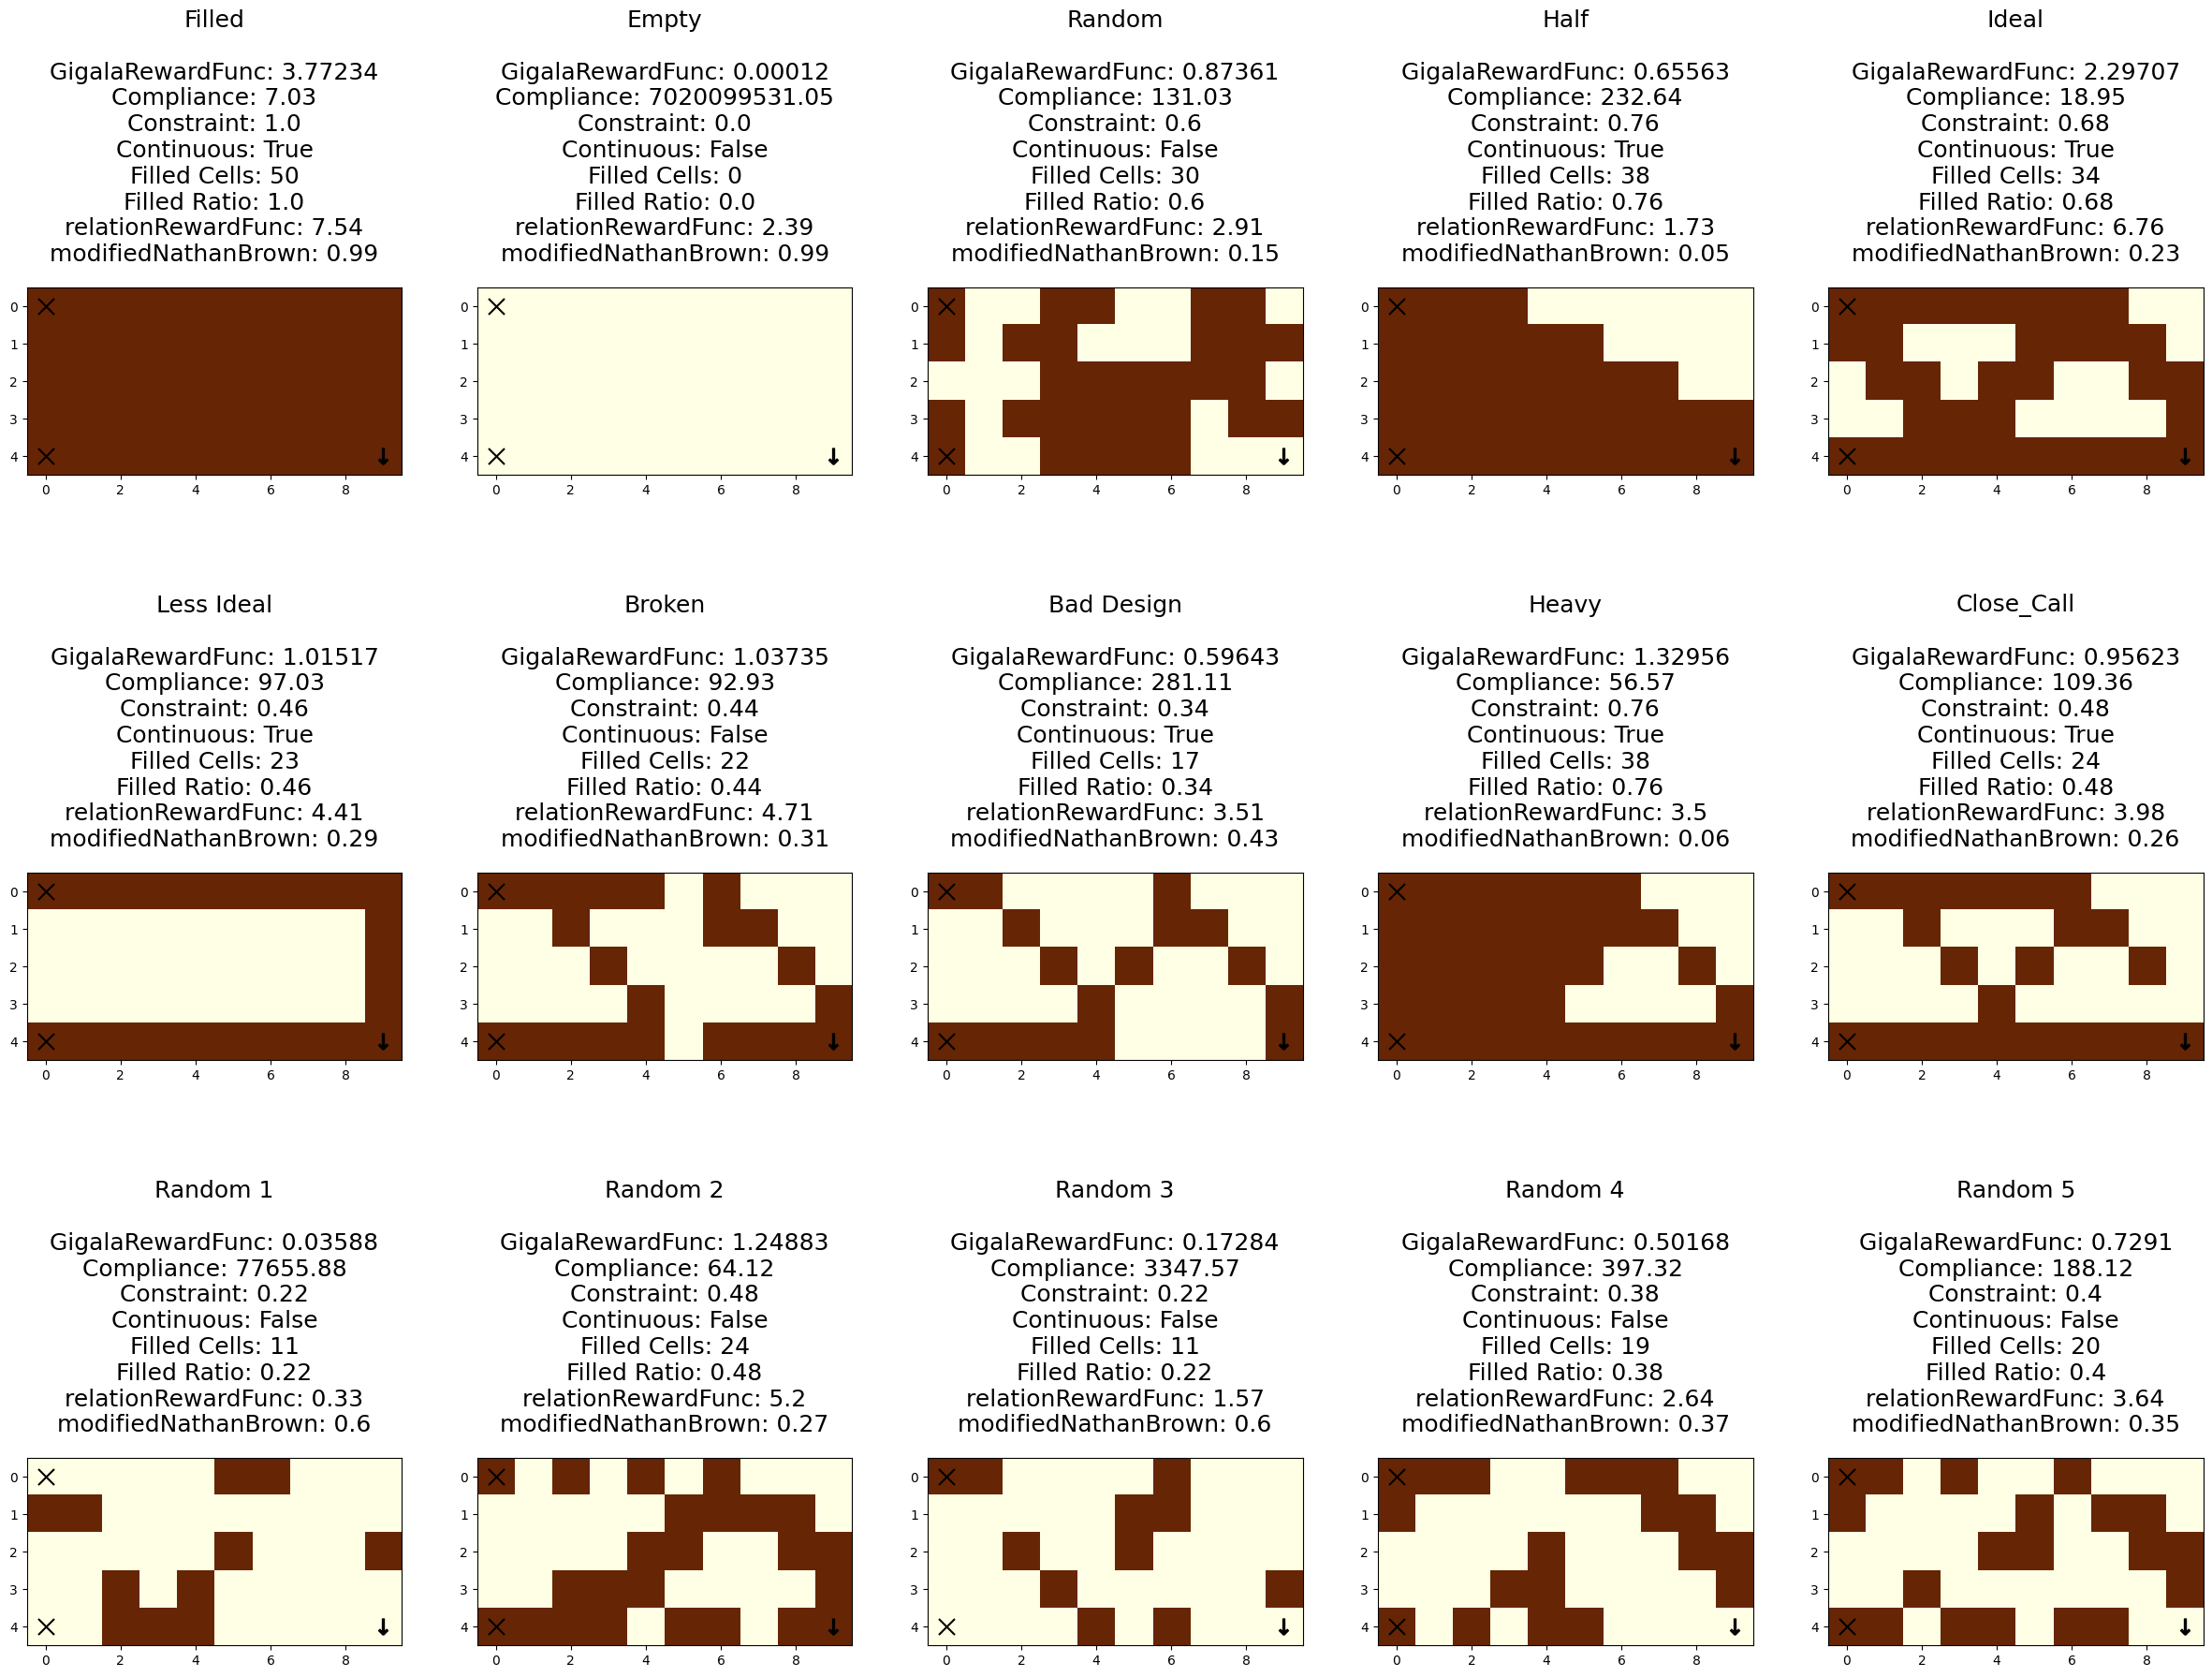

[(0, 0), (-1, 0)]
Showcasing a Design Process with the Reward Functions and Compliance Values:


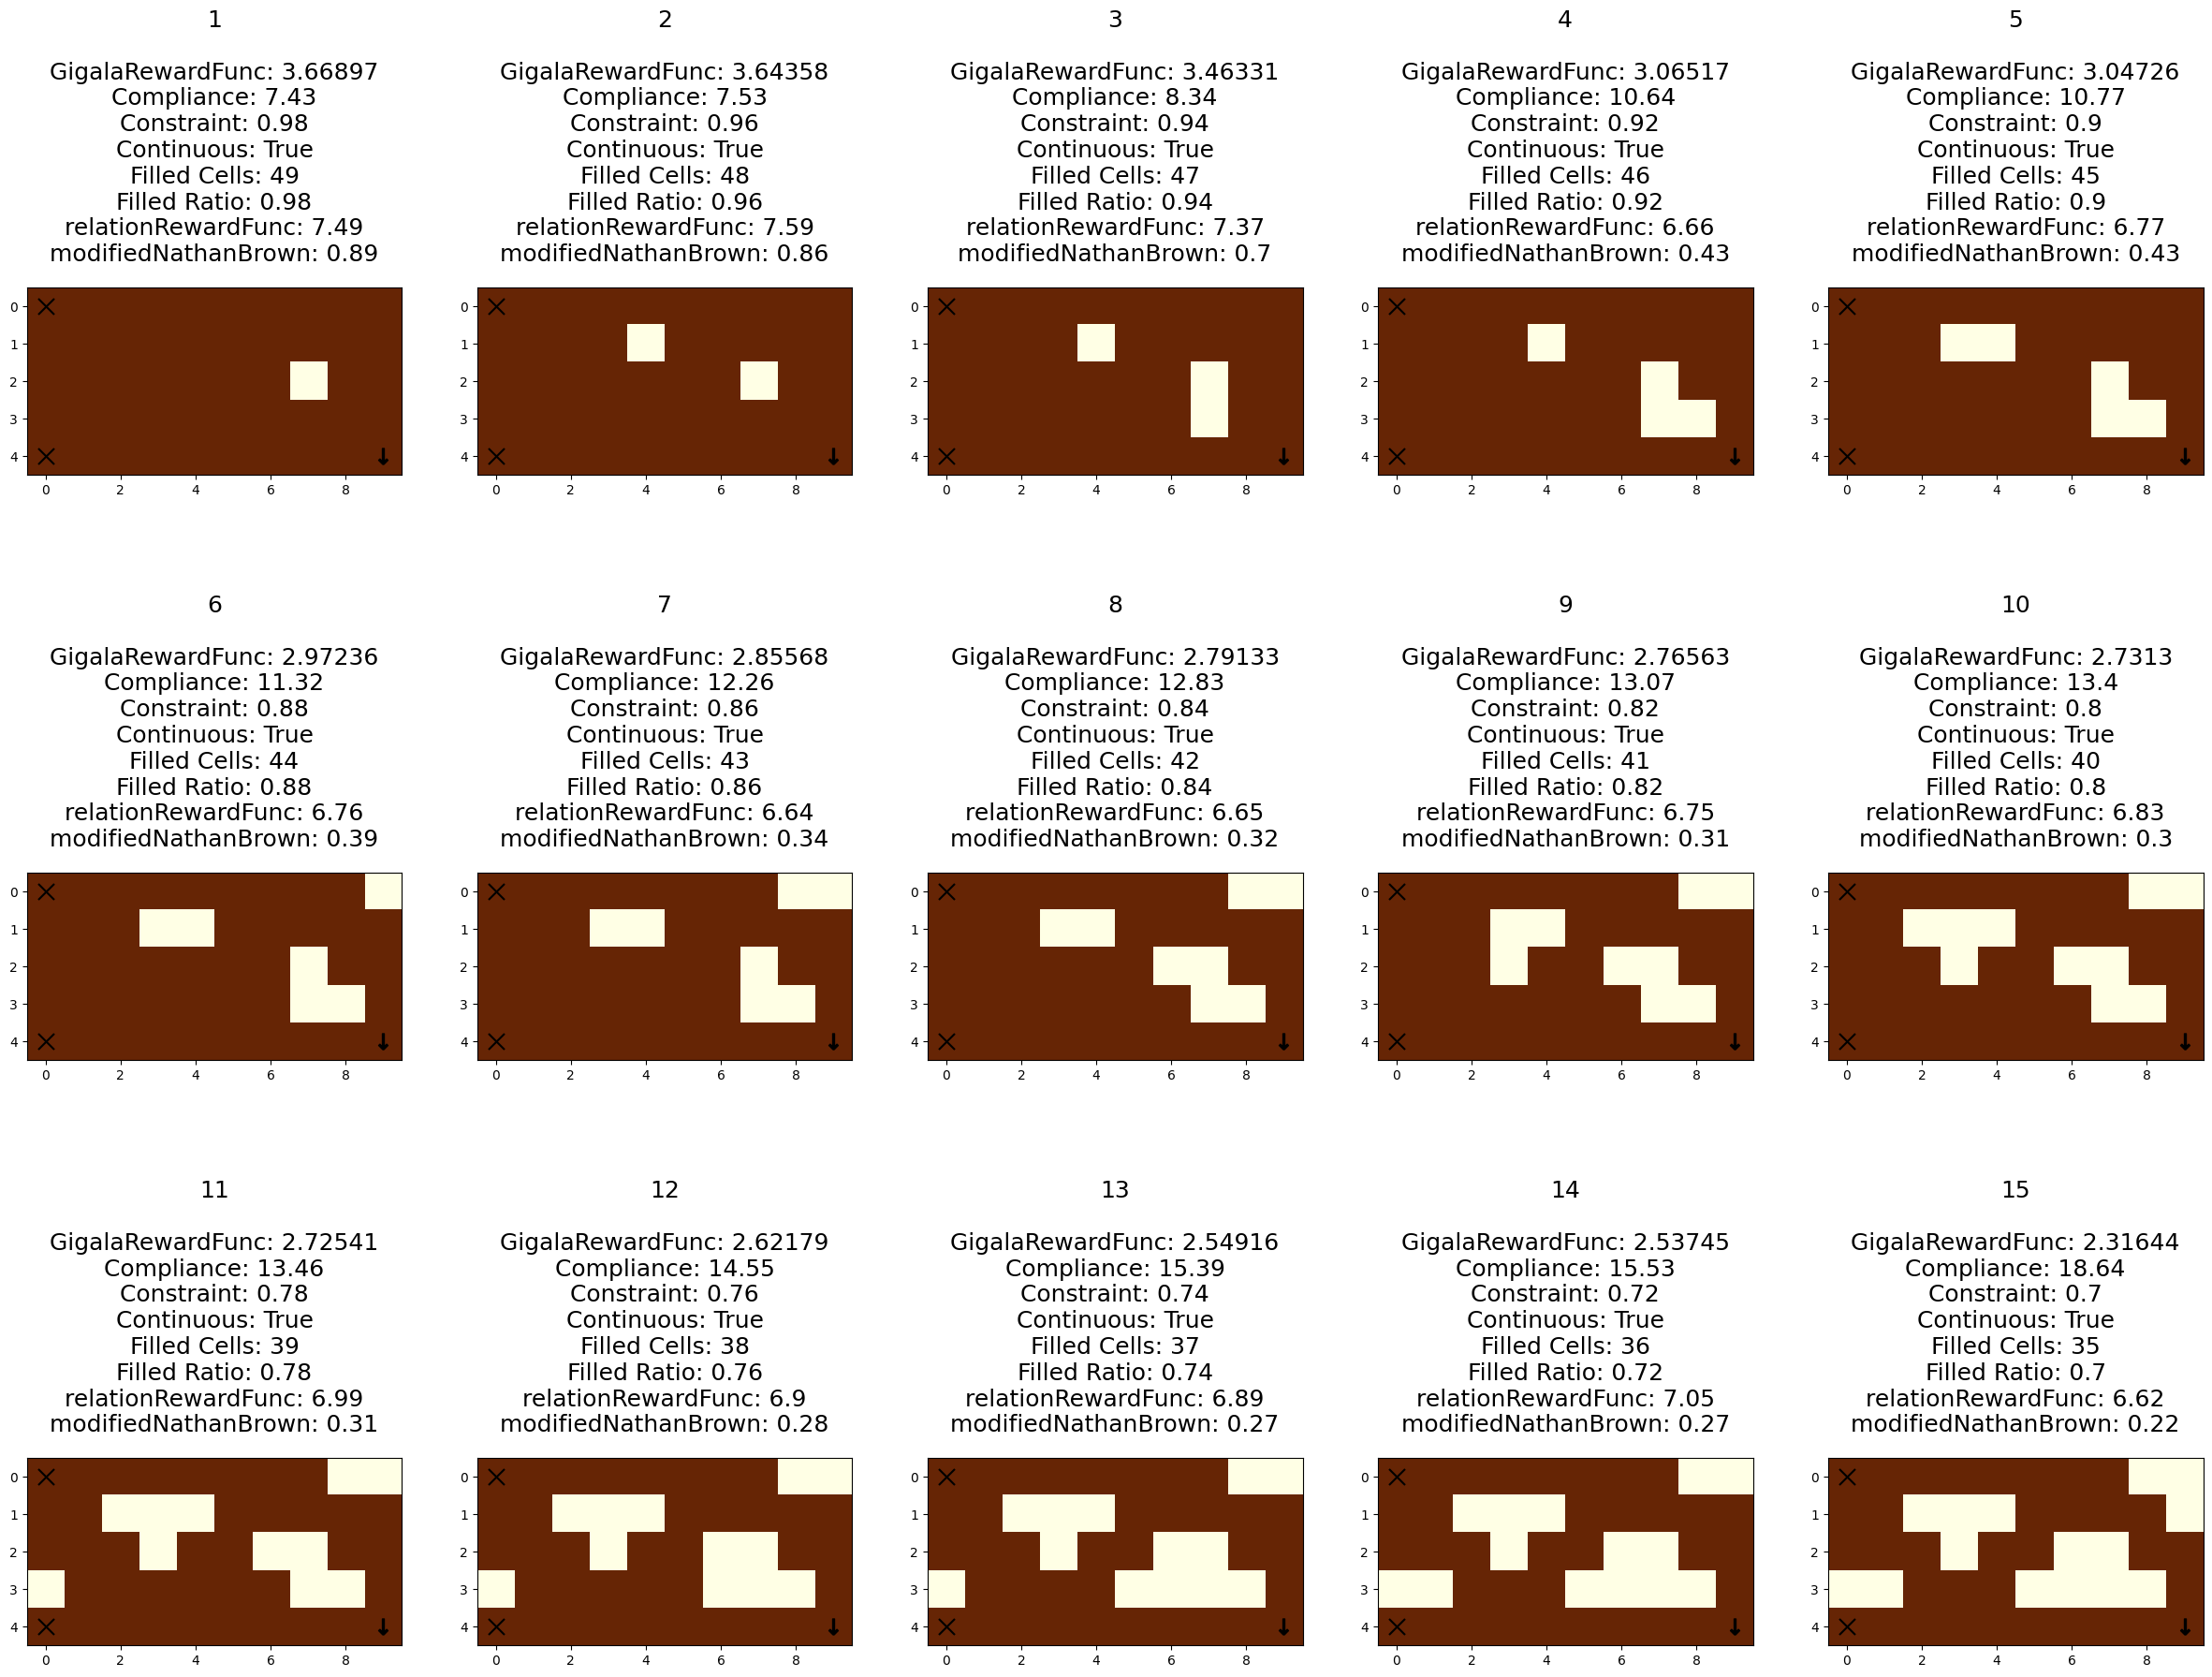

In [67]:
#TESTING



def render_all(states):
    """This function is used to render the different design spaces with their
    respective reward functions and compliance values.

    Parameters
    ----------
    states : list
        The list containing the different design spaces.

    Returns
    -------
        None
    """
    num_rows = 3
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 23))
    for i, state in enumerate(states):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].imshow(states[i]["matrix"].reshape(height, width), vmin=density, vmax=1)
        title = (state["Name"]
        + "\n\nGigalaRewardFunc: " + str(round(state["rewardfunc"], 5))  
        + "\nCompliance: " + str(round(state["Compliance"], 2))
        + "\nConstraint: " + str(round(state["constraint"], 3)) 
        + "\nContinuous: " + str(state["continuous"])
        + "\nFilled Cells: " + str(state["filled_cells"])
        + "\nFilled Ratio: " + str(round(state["filled_ratio"], 3))
        + "\nrelationRewardFunc: " + str(round(state["reward1"], 2))
        + "\nmodifiedNathanBrown: " + str(round(state["reward2"],2)))
        axs[row, col].scatter(x_bound_positions_for_scatter, 
                              y_bound_positions_for_scatter, 
                              s=150, color='k', marker='x')
        axs[row, col].scatter(x_loaded_positions_for_scatter, 
                              y_loaded_positions_for_scatter, 
                              s=150, color='k', marker='$↓$')
        axs[row, col].set_title(title, fontsize=18, pad=20)
    plt.show()


def flip_random_elements(matrix):
    matrix_copy = np.copy(matrix)
    rows, cols = matrix_copy.shape
    num_elements_to_flip = np.random.randint(1, rows*cols)
    row_indices = np.random.randint(0, rows, num_elements_to_flip)
    col_indices = np.random.randint(0, cols, num_elements_to_flip)
    for row, col in zip(row_indices, col_indices):
        matrix_copy[row, col] = 1 if matrix_copy[row, col] == density else density
    return matrix_copy

def turn_random_density_to_one(matrix):
    matrix_copy = np.copy(matrix)
    zero_indices = np.argwhere(matrix_copy == density)
    if zero_indices.size == density:
        return matrix_copy
    random_index = zero_indices[np.random.choice(zero_indices.shape[0])]
    matrix_copy[tuple(random_index)] = 1
    return matrix_copy

def zero_to_densitiy(matrix):
    return np.where(matrix == 0, density, matrix)


test_bound_matrix = np.zeros((height, width))
test_force_matrix = np.zeros((height, width))

for coord in convert_all(bound_nodes_list, (height, width)):
            test_bound_matrix[coord[0],coord[1]] = 1
for coord in convert_all(loaded_nodes_list, (height, width)):
            test_force_matrix[coord[0],coord[1]] = 1  

test_freedofs, test_fixdofs = calculate_dofs(test_bound_matrix)
test_forces = calculate_forces(test_force_matrix)

print("Freedofs: ", test_freedofs)
print("Fixdofs: ", test_fixdofs)
print("Forces: ", test_forces)


# create the initial compliance of a completely filled in design space
initial_compliance = get_compliance(np.ones((height, width)), test_freedofs, 
                                    test_fixdofs, test_forces)

states = []
matrices = []

# Here we create the different matrices that we want to showcase
# First a fully filled in Matrix
filled_matrix = np.ones((height, width))
matrices.append(filled_matrix)

# An Empty Matrix
empty_matrix = zero_to_densitiy(np.zeros((height, width)))
matrices.append(zero_to_densitiy(empty_matrix))

# A randomly generated Matrix
random_matrix = np.random.choice([density, 1], (height, width))
matrices.append(random_matrix)

# A half filled in Matrix
half_matrix = [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(half_matrix))

# A Matrix which represents a more or less ideal design
ideal_matrix = [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [1, 1, 0, 0, 0, 1, 1, 1, 1, 0],
                [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
                [0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(ideal_matrix))

# A Matrix which represents a worse design
less_ideal_matrix = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(less_ideal_matrix))

# A copy of the ideal design, with a break in it
broken_matrix = [[1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(broken_matrix))

# A Matrix which represents a very elastic design
bad_design = [[1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
              [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
              [1, 1, 1, 1, 1, 0, 0, 0, 0, 1]]
matrices.append(zero_to_densitiy(bad_design))

# A matrix which represents a stiff but heavy design
heavy_matrix = [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
                [1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
matrices.append(zero_to_densitiy(heavy_matrix))

# A copy of the ideal matrix with a crucial node missing
close_call_matrix = zero_to_densitiy([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                                      [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
                                      [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
                                      [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
matrices.append(zero_to_densitiy(close_call_matrix))

# A few copies of the ideal matrix with a few random elements flipped
random_matrix_1 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_1)
random_matrix_2 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_2)
random_matrix_3 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_3)
random_matrix_4 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_4)
random_matrix_5 = flip_random_elements(ideal_matrix)
matrices.append(random_matrix_5)

# for some reason the zero_to_density funcion only works if doing it twice
matrices = list(map(lambda matrix: zero_to_densitiy(matrix), matrices))

# Here we create a list of names for the different matrices
matrix_names = ["Filled", "Empty", "Random", "Half", "Ideal", "Less Ideal", "Broken", "Bad Design", "Heavy", "Close_Call", "Random 1", "Random 2", "Random 3", "Random 4", "Random 5"]
# init the dictionary
matrix_dict = {}




# fill the dictionary with the matrices and their respective names
# calculate the reward functions and compliance values
# and add them to the states list
for name, matrix in zip(matrix_names, matrices):
    scaled_matrix= scale_matrix(matrix, height, width)
    state = {
        "matrix" : scaled_matrix, 
        "Name" : name, 
        "rewardfunc" : rewardFunction_old(scaled_matrix, test_freedofs, test_fixdofs, test_forces), 
        "constraint" : constraintFunction(scaled_matrix),
        "Compliance" : objective(scaled_matrix, test_freedofs, test_fixdofs, test_forces), 
        "continuous" : is_continuous(scaled_matrix, bound_nodes_list + loaded_nodes_list),
        "filled_cells" : get_filled_cells(scaled_matrix),
        "filled_ratio": get_filled_cells(scaled_matrix) / number_of_nodes,
        "reward1" : rewardFunction_1(scaled_matrix, test_freedofs, test_fixdofs, test_forces),
        "reward2" : rewardFunction_2(scaled_matrix, get_compliance(scaled_matrix, test_freedofs, test_fixdofs, test_forces), 
                                     initial_compliance, get_compliance(scaled_matrix, test_freedofs, test_fixdofs, test_forces))
    }
    states.append(state)
print("Different Matrices with their respective Reward Functions and Compliance Values:")
render_all(states)

# reset the different lists for the second test run
states.clear()
matrices.clear()
matrix_names.clear()
matrix_dict.clear()

# again for some reason zero_to_density only works if done twice
ideal_matrix = zero_to_densitiy(ideal_matrix)
matrices.append(zero_to_densitiy(ideal_matrix))

# create a copy of the last matrix in the list, turn a random voided element
# into a filled one and add it to the matrices list.
# continue doing so to simulate 15 steps of a design process to analyse the
# reward functions and compliance values
for i in range(0, 15):
    temp = turn_random_density_to_one(matrices[i])
    temp = zero_to_densitiy(temp)
    matrices.append(temp)

# reverse the list of matrices to get the correct order
matrices.reverse()
matrix_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"]
print(bound_nodes_list)
for name, matrix in zip(matrix_names, matrices):
    scaled_matrix= scale_matrix(matrix, height, width)
    state = {
        "matrix" : scaled_matrix, 
        "Name" : name, 
        "rewardfunc" : rewardFunction_old(scaled_matrix, test_freedofs, test_fixdofs, test_forces), 
        "constraint" : constraintFunction(scaled_matrix),
        "Compliance" : objective(scaled_matrix, test_freedofs, test_fixdofs, test_forces), 
        "continuous" : is_continuous(scaled_matrix, bound_nodes_list + loaded_nodes_list),
        "filled_cells" : get_filled_cells(scaled_matrix),
        "filled_ratio": get_filled_cells(scaled_matrix) / number_of_nodes,
        "reward1" : rewardFunction_1(scaled_matrix, test_freedofs, test_fixdofs, test_forces),
        "reward2" : rewardFunction_2(scaled_matrix, get_compliance(scaled_matrix, test_freedofs, test_fixdofs, test_forces), 
                                     initial_compliance, get_compliance(scaled_matrix, test_freedofs, test_fixdofs, test_forces))
    }
    states.append(state)
print("Showcasing a Design Process with the Reward Functions and Compliance Values:")
render_all(states)

# Explaining the different Values

- oldRewardfunction returns $\sqrt{\left(\frac{1}{compliance}\right)}$ with the compliance representing the elasticity of the design this is the original reward function by gigala
- Compliance represents the current Elasticity Factor of the Design. It is the Inverse of the Stiffness
- Constraint is the normalized volume of the design
- Continuous is a Boolean representing if the Bounded Node is connected to the Node which has a force applied to it
- Filled Cells is the Number of cells, which are currently filled in
- Reward1 is the value of the naive rewardFunction written by me
- Reward2 is the value of the modified reward function used by Nathan Brown

# Planning the Enviroment
## Variables
- __initial_compliance__
    - This Variable will store the compliance Value of a completely filled in design space
    - this is needed for the Reward function
- __design_space:__
    - This will be a Matrix consisting of filled and voided Elements, represented by ones and the density constant.
    - It will have the Dimensions set in the Parameters Cell
    - It should be initialized to be completely filled
- __bound_nodes:__
    - This will be a Matrix consisting of ones and zeros, representing which Elements are bounded
    - It will be of the same Dimensions as design_space
    - It will get the coordinates of bounded nodes from the bound_node_list in the Parameters Cell
- __force_nodes:__
    - This will be a Matrix consisting of ones and zeros, representing which Elements have a force applied to them
    - It will be of the same Dimensions as design_space and bound_nodes
    - It will get the coordinates of loaded nodes form the force_node_list in the Parameters Cell
- __action_space__:
    - This Variable is required by the gym Module for any Reinforcement Learning Enviroment
    - It will tell training agent how many actions it can take.
    - In our case it is going the be set as many discrete actions, as there are Elements in the Design Space
- __actions_to_coordinates__:
    - This will be a Dictionary with one key. The key being an Integer and the associated Value being a Tuple
    - The Number will be incrementing from zero to number_of_nodes, which represents the amount of Elements in the design space
    - This Number will be connected to a Tuple, representing the coordinates of an Element in the Design space
    - This will make it poosible for the reinforcment learning agent to choose actions as simple Integers, which then will be equated to an Element in the Design Space
    - In this way, choosing a number as action can be used to remove an Element from the Design Space
    - Example: 0: (0,0), 1: (0, 1), 2: (1, 0), 3: (1, 1), ..... number_of_nodes: (height, width)
- __performed_actions:__
    - This will simply be a list that keeps track of which actions have previously been performed in this Episode
    - It will be used as an Ending criteria, as well as in the rewarding of actions
- __reward:__
    - This Variable will simply keep track of the current reward of the Episode
- __step_count__
    - This Varuable will be used to count the number of steps that have taken place in this Episode
    - might be used fot ending criteria or rewarding

## Functions
- __init(self)__
    - This Function will initialize the Enviroment, so it will call the super constructor
    - The Variables we should initialize here are:
        - __design_space__ as matrix of dimensions __height__ and __width__, where every Element equals 1 
        - __bound_nodes__ as matrix filled with ones and zeros according to __bound_nodes_list__
        - __force_nodes__ as matrix filled with ones and zeros according to __force_nodes_list__
        - __action_space__ as gym.spaces.Discrete Object with length __number_of_nodes__
        - __observation_space__ as gym.spaces.Box Object with Dimensions __height__ and __width__
        - __reward__ with value 0
        - __step_count__ with value 0
    - also the __actions_to_coordinates__ dictionary should be initialized 
    - lastly it should call the __reset(self)__ function to reset as well as initialize all the Values, that get set there.

- __step(self)__: 

<p align="center">
  <img src="Media/step_function_diagram.png" alt="Step Function Diagram">
</p>

- __reset(self)__:
    - This function will reset Variables, that need to be a certain Value at the beginning of an Episode to their correct inital Value
    -



In [53]:
_DESIGN = 0
_BOUND = 1
_FORCE = 2
_COMPLIANCE = 3

In [78]:
class TopOptEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, mode="train", threshold=0.5, bound_nodes_list=bound_nodes_list, force_nodes_list=loaded_nodes_list, height=height, width=width):
        # The constructor of the environment
        super().__init__()

        self.mode = mode
        self.threshold = threshold

        self.height = height
        self.width = width
        
        
        self.bound_nodes_list = bound_nodes_list
        self.force_nodes_list = force_nodes_list
        self.initial_compliance = 0
        self.design_space = np.zeros((self.height, self.width, 4))


        self.action_space = gym.spaces.Discrete(self.height * self.width)
        self.observation_space = gym.spaces.Box(low=0, 
                                                high=1, 
                                                shape=(height, width, 4), 
                                                dtype=np.float64)
        
        # A Dictionary is used to map each coordinate tuple of the designspace
        # to a singular distinct integer for use in the optimization
        # 0 = (0,0), 1 = (0,1), 2 = (0,2), ... , number_of_nodes = (height,width)
        self._actions_to_coordinates = {}  
        k=0
        for i in range(self.height):
            for j in range(self.width):
                self._actions_to_coordinates[k] = (i,j)
                k += 1
        
        self.reward = 0
        self.step_count = 0

        self.reset()
        
    def _is_illegal_action(self, action):
        bound_matrix = self.design_space[:,:, _BOUND]
        force_matrix = self.design_space[:,:, _FORCE]
        design_matrix = self.design_space[:,:, _DESIGN]

       
        # Check if the selected Action has already been performed on this state
        if action in self.performed_actions:
            return True
        #check if the selected Node is either bound or force node
        if bound_matrix[self._actions_to_coordinates[action]] == 1:
            return True
        if force_matrix[self._actions_to_coordinates[action]] == 1:
            return True
        #Check if the selected Node is already removed
        if design_matrix[self._actions_to_coordinates[action]] < 1:
            return True
        if not is_continuous(design_matrix, 
                             self.bound_nodes_list + self.force_nodes_list):
            return True

    def step(self, action):


        self.step_count += 1
        terminated = False

        if self._is_illegal_action(action):
            self.reward = -1
            terminated = True
            return self.design_space, self.reward, terminated, False, self.get_info()
        
        design_matrix = self.design_space[:,:, _DESIGN]
        compliance_matrix = self.design_space[:,:, _COMPLIANCE]
        
        self.last_compliance = self.compliance

        self._remove_node(action)
        self.compliance = get_compliance(design_matrix, self.freedofs, 
                                         self.fixdofs, self.forces)
        
        compliance_matrix = get_compliance_per_element(design_matrix, 
                                                       self.freedofs, 
                                                       self.fixdofs, 
                                                       self.forces)
        
        self.vectorized_sigmoid = np.vectorize(self.sigmoid) 
        compliance_matrix = self.vectorized_sigmoid(compliance_matrix)

        self.constraint = constraintFunction(design_matrix)

        # print("\n\nstep Debug ====================================")
        # print("Step: ", self.step_count)
        # print("Compliance: ", self.compliance)
        # print("initial_compliance: ", self.initial_compliance)
        # print("last_compliance: ", self.last_compliance)
        # print("Constraint: ", self.constraint)
        # # print("Reward: ", self.reward)
        # print("freedofs: ", self.freedofs)
        # print("fixdofs: ", self.fixdofs)
        # print("forces: ", self.forces)
        # print("design_space[:,:,_DESIGN]:\n", self.design_space[:,:, _DESIGN])
        # print("design_space[:,:,_BOUND]:\n", self.design_space[:,:, _BOUND])
        # print("design_space[:,:,_FORCE]:\n", self.design_space[:,:, _FORCE])

        self.reward += rewardFunction_2(design_matrix, self.compliance, 
                                        self.initial_compliance, 
                                        self.last_compliance)
        
        self.performed_actions.append(action)

        if self.mode == "eval" and self.constraint < self.threshold:
            terminated = True

        self.design_space[:, :, _DESIGN] = design_matrix
        self.design_space[:, :, _COMPLIANCE] = compliance_matrix

        

        return self.design_space, self.reward, terminated, False, self.get_info()



    def _remove_node(self, action):
        design_matrix = self.design_space[:,:, _DESIGN]
        design_matrix[self._actions_to_coordinates[action]] = density    
        self.design_space[:,:,_DESIGN] = design_matrix
    
    def sigmoid(self, x, k=1):
        z = -k * x
        threshold = np.log(np.finfo(np.float64).max)
        if z > threshold:
            return 1.0
        if z < -threshold:
            return 0.0
        return 1 / (1 + np.exp(-k * x))


    def reset(self, seed=None):
        # The reset function of the environment

        super().reset(seed=seed)
       
        self.step_count = 0
        self.reward = 0
        self.performed_actions = []
        self.design_space = np.zeros((self.height, self.width, 4))
        self.design_space[:,:, _DESIGN] += 1

        design_matrix = self.design_space[:,:, _DESIGN]
        bound_matrix = self.design_space[:,:, _BOUND]
        force_matrix = self.design_space[:,:, _FORCE]
        compliance_matrix = self.design_space[:,:, _COMPLIANCE]

        if self.mode == "train":
            self.bound_nodes_list = []
            self.bound_nodes_list.extend([self.generate_random_coordinate(), 
                                          self.generate_random_coordinate()])

            self.force_nodes_list = []
            self.force_nodes_list.append(self.generate_random_coordinate()),
        

        for coord in convert_all(self.bound_nodes_list, (self.height, self.width)):
            bound_matrix[coord] = 1
        for coord in convert_all(self.force_nodes_list, (self.height, self.width)):
            force_matrix[coord] = 1  



        self.freedofs, self.fixdofs = calculate_dofs(bound_matrix)
        self.forces = calculate_forces(force_matrix)
        # print("\n\ncompliance Debug ====================================")
        # print("design_matrix:\n", design_matrix)
        # print("freedofs: ", self.freedofs)
        # print("fixdofs: ", self.fixdofs)
        # print("forces: ", self.forces)
        self.initial_compliance = get_compliance(design_matrix, self.freedofs, 
                                                 self.fixdofs, self.forces)
        
        compliance_matrix = get_compliance_per_element(design_matrix, 
                                                       self.freedofs, 
                                                       self.fixdofs, 
                                                       self.forces)

        self.vectorized_sigmoid = np.vectorize(self.sigmoid) 
        compliance_matrix = self.vectorized_sigmoid(compliance_matrix)
        
        self.compliance = self.initial_compliance
        self.last_compliance = self.initial_compliance

        self.design_space[:, :, _DESIGN] = design_matrix
        self.design_space[:, :, _BOUND] = bound_matrix
        self.design_space[:, :, _FORCE] = force_matrix
        self.design_space[:, :, _COMPLIANCE] = compliance_matrix

        # print("\n\nReset Debug ====================================")
        # print("Initial Compliance:\n", self.initial_compliance)
        # print("design_matrix:\n", design_matrix)
        # print("design_space[:,:,_DESIGN]:\n", self.design_space[:,:, _DESIGN])
        # print("bound_matrix:\n", bound_matrix)
        # print("design_space[:,:,_BOUND]:\n", self.design_space[:,:, _BOUND])
        # print("force_matrix:\n", force_matrix)
        # print("design_space[:,:,_FORCE]:\n", self.design_space[:,:, _FORCE])
        # print("compliance_matrix:\n", compliance_matrix)
        # print("Initial Reward:\n", self.reward)

        return self.design_space, self.get_info()



    def is_valid_coordinate(self, coord, node_lists):
    # Check adjacent positions
        checking_positions = [
            (coord[0], coord[1]),  # Current
            (coord[0] - 1, coord[1]),  # Left
            (coord[0] + 1, coord[1]),  # Right
            (coord[0], coord[1] - 1),  # Up
            (coord[0], coord[1] + 1),  # Down
        ]
        # Check if any adjacent position is in the node lists
        for pos in checking_positions:
            if any(pos in node_list for node_list in node_lists):
                return True
        return False

    def generate_random_coordinate(self):
        axis = random.randint(0, 1)
        if axis == 0:
            coord = random.randint(0, height-1), 0
        else:
            coord = 0, random.randint(0, width-1)
        # Check if the coordinate is in the lists or next to any node in the lists
        comp_list = [self.bound_nodes_list, self.force_nodes_list]
        
        if (coord in self.bound_nodes_list or 
            coord in self.force_nodes_list or 
            self.is_valid_coordinate(coord, comp_list)):
            
            return self.generate_random_coordinate()
        else:
            return coord 
    

    
    def render(self, mode="human"):
        # This function is used to render the environment
        # This function is not necessary for the optimization
        print("current Design")
        fig, ax = plt.subplots()
        ax.imshow(self.design_space[:, :, _DESIGN])
        ax.scatter(x_bound_positions_for_scatter, 
                   y_bound_positions_for_scatter, 
                   s=150, color='k', marker='x')
        ax.scatter(x_loaded_positions_for_scatter, 
                   y_loaded_positions_for_scatter, 
                   s=150, color='k', marker='$↓$')
        plt.show()


    def get_info(self):
        # This function returns the information about the environment
        # This function is used to monitor the environment
        # The information should be a dictionary
        # The dictionary should contain the following keys:
        # - step_count: the number of steps that have been executed
        # - current Reward: the reward of the current state
        # - design_space: the current state of the environment
        return {"step_count": self.step_count, 
                "current_reward": self.reward,
                "design_space": self.design_space[:, :, _DESIGN]}


In [55]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)s
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            # os.makedirs(self.save_path, exist_ok=True
            return

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("---------------------------------------------------------")
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                #vecenv_render(env)
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    

        return True

In [77]:
#
#env = SubprocVecEnv([lambda: TopOptEnv() for _ in range(number_subprocesses)]) #### trying to multiprocess
env = TopOptEnv()
#check_env(env, warn=True)

# Logs will be saved in log_dir/monitor.csv
#env = VecMonitor(env, log_dir)

env = Monitor(env, log_dir)
#check_env(env, warn=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

sess = tf.compat.v1.Session()
file_writer = tf.summary.create_file_writer(ts_board_dir)
with file_writer.as_default():
    tf.summary.graph(sess.graph)





[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]


C:\Users\adrian\AppData\Local\Temp\ipykernel_13428\797002424.py:131: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * x))


In [57]:
def vecenv_render(env):
    plt.close()
    design_spaces = env.env_method("getInfo")
    fig, axs = plt.subplots(1,number_subprocesses)
    fig.set_size_inches(20, 10)
    
    for i in range(number_subprocesses):
        axs[i].imshow(design_spaces[i]["design_space"],vmin=density, vmax=1)
        current_reward = design_spaces[i]["current_reward"]
        title = (str(i+1) + "\nReward= " + str(round(current_reward, 1)))
        axs[i].scatter(x_bound_positions_for_scatter, 
                       y_bound_positions_for_scatter, 
                       s=20, color='k', marker='x')

        axs[i].scatter(x_loaded_positions_for_scatter, 
                       y_loaded_positions_for_scatter, 
                       s=20, color='k', marker='$↓$')
        axs[i].set_title(title, fontsize=11, pad=10)
        
    
    plt.show()    




In [58]:
%tensorboard --logdir ts_board_dir

Reusing TensorBoard on port 6006 (pid 2484), started 2 days, 7:30:31 ago. (Use '!kill 2484' to kill it.)

In [79]:
start=time.time()
model = PPO("MlpPolicy", env, tensorboard_log=ts_board_dir).learn(total_timesteps=ts, callback=callback)
end=time.time()   
print("Elapsed Time = " + str(end-start))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0

C:\Users\adrian\AppData\Local\Temp\ipykernel_13428\797002424.py:131: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * x))


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0

RuntimeError: Factor is exactly singular

Step 1
current Design


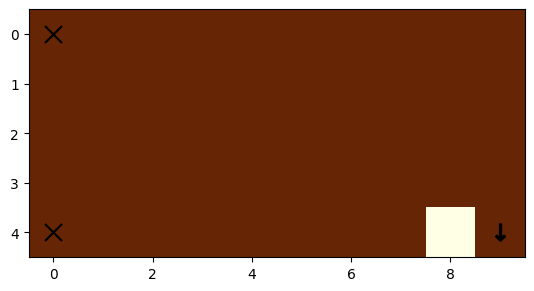

Step 2
Step 3
Goal reached! reward= -1
current Design


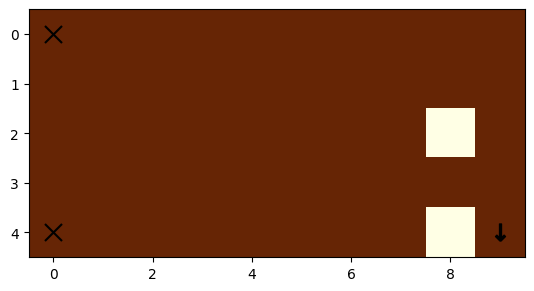

In [ ]:
#env.close()
env = TopOptEnv(mode="eval", threshold= 0.1)
model_best = PPO.load("log/best_model",env=env)
obs, _ = env.reset()
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    action = action.item()
    print(f"Step {i + 1}")
    # print("Action: ", action)       # added Console Outputs for better understanding  
    obs, rewards, dones, _, info = env.step(action)
    if i%10 == 0:
        env.render()
    if dones:
        print("Goal reached!", "reward=", rewards)
        env.render()
        break
    i+=1





In [ ]:
# TODO test 5x10 with removing the plus 1 at the gigala normals matrix
# 
# TODO Check different Compliance Thresholds
# 
#
# 
# TODO Comment comment comment
# 

# TODO Scale the Fonts in the Vecenv_render Function accordingly to the design space size
# 
# 
# Maybe add scaling to the reinforcement learning:
# Scale the matrix down to where either width or height is the smallest common multiple of the two
# get the "rough shape" from there, and then scale it up and removing the "excess" nodes
# so it progressively refines the structure


# Or maybe break the design space into smaller parts and then train the model on those
# Where would the forces and Bounds Be?
